# Final Project - Reinforcements Learning 
## Experimentation Notebook

---
<br>

### Name and ID:
Student 1: Roei Arpaly, xxxxxxxxx
<br>
Student 2: Ron Darmon, xxxxxxxxx
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# General

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

## Imports

In [ ]:
import numpy as np
import gym
from gym.utils import seeding
from gym import error, spaces, utils
from gym import logger as gymlogger
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import gc

# Viz Report
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Keras
import keras
from collections import deque
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, ReLU, LeakyReLU
from keras.optimizers import Adam
from keras.optimizers.schedules.learning_rate_schedule import ExponentialDecay

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()  # Check if GPU is available

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15735818441827923935
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14385217536
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16539882475761325483
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def video_func(env, agent, fps=10):
    start_time = time.time()
    done = False
    iter = 0
    video_filename = 'imageio.mp4'
    state = env.reset()
    state = np.expand_dims(state, axis=0)
    with imageio.get_writer(video_filename, fps=fps) as video:
      video.append_data(env.render(mode='rgb_array'))
      while (iter < 10) or not done:
        time_passed = int(time.time() - start_time)
        if done or time_passed > 3:
          break
        iter +=1

        action = np.argmax(agent.model.predict(state, verbose=0)[0])
        if agent.tiny_action_lookup:
            action = agent.tiny_action_lookup[action]

        state, reward, done, info = env.step(action, reward_shaping=False)
        state = np.expand_dims(state, axis=0)
        video.append_data(env.render(mode='rgb_array'))
        
    return embed_mp4(video_filename)

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
# Given an environment it will print us the details about observation, actions, agent's position and boxes locations
def print_env_det(env):
    print(f'Observation space: {env.observation_space}'
          f'\nAction space: {env.action_space}'
          f'\nPlayer position:{env.player_position}'
          f'\nBox mapping (end, start): {env.box_mapping}'
          f'\nBox New Position: {env.new_box_position}'
          f'\nBox Old Position: {env.old_box_position}'
          )

---

# EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

## Feeling the Env

In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1)
# ============================================

In [ ]:
class EnvWrapper(gym.Wrapper):
    def __init__(self, env, dim_room, num_boxes, max_steps, seed=2, mode='tiny_rgb_array', crop=True):
        super().__init__(env)

        self.seed = seed
        self.dim_room = dim_room
        self.num_boxes = num_boxes
        self._max_steps = max_steps
        self._mode = mode
        self._crop = crop
        
        # The wrapper encapsulates and initialize the gym env
        self.env = env(dim_room=self.dim_room, num_boxes=self.num_boxes, max_steps=self._max_steps)
        self.last_state = self.reset()
    
    def xs_observation(self, state):
        if self._mode == 'rgb_array' and not self._crop:
            return state
        elif self._mode == 'rgb_array' and self._crop:
            return state[14:-14, 14:-14, :]
        elif self._mode == 'tiny_rgb_array':
            return state[1:-1, 1:-1, :]
        else:  # grayscale
            return state[1:-1, 1:-1, 0:1]
              
    def step(self, action, reward_shaping=False):
        next_state, reward, done, info = self.env.step(action, observation_mode=self._mode)
        next_state = self.xs_observation(next_state)
        self.num_step += 1
        self._box_position = np.hstack(np.where(self.env.room_state == 4))  # Take box position (4)

        if len(self._box_position) > 0 and reward_shaping:
            distance_to_target = np.sum(np.abs(np.array(self.end_location) - np.array(self._box_position)))
            distance_to_box = -1 + np.sum(np.abs(np.array(self._box_position) - np.array(self.env.player_position)))
            reward -= distance_to_target
            reward -= distance_to_box
        return next_state, reward, done, info
    
    def reset(self):
        if self.seed:
            random.seed(self.seed)
        self.num_step = 0
        state = self.env.reset()
        state = self.env.render(mode=self._mode)

        self.end_location = list(self.env.box_mapping.keys())[0]
        self.start_location = list(self.env.box_mapping.values())[0]
        self._box_position = self.start_location
        state = self.xs_observation(state)
        return state

In [ ]:
ACTION_LOOKUP = {
    0: 'no operation',
    1: 'push up',
    2: 'push down',
    3: 'push left',
    4: 'push right',
    5: 'move up',
    6: 'move down',
    7: 'move left',
    8: 'move right',
    9: 'pull up',
    10: 'pull down',
    11: 'pull left',
    12: 'pull right',
}

tiny_action_lookup = {0:1, 1:2, 2:3, 3:4, 4:9, 5:10, 6:11, 7:12}  # use partial moves

### Play and debug the environment
using W-A-S-D for push and 2-4-6-8 to pull

In [ ]:
from IPython import display

sok = EnvWrapper(env=PushAndPullSokobanEnv, dim_room=(7,7), num_boxes=1, max_steps=120, seed=2)
simplify_playing = {'w': 1, 'a': 3, 's': 2, 'd': 4, '8': 9,
                    '2': 10, '4': 11, '6': 12, '0': 0}

def playground():
    observation = sok.reset()
    plt.imshow(sok.render('rgb_array'))
    plt.show()
    plt.close()
    display.clear_output()
    action = simplify_playing.get(input('Action: '))
    while True:
      if action not in simplify_playing.values():
        break
      observation, reward, done, info = sok.step(action, True)
      plt.imshow(sok.render('rgb_array'))
      plt.show()
      print_env_det(sok)
      print('Reward:', reward, 'Done:', done)
      action = simplify_playing.get(input('Action: '))
      plt.close()
      display.clear_output()

# playground()

Action: break


## EX1 - Video test

In [ ]:
env = EnvWrapper(env=PushAndPullSokobanEnv, dim_room=(7,7), num_boxes=1, max_steps=120, seed=2)
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action, reward_shaping=False)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---

## EX1 - Solution

In [ ]:
class DQNAgent:
    def __init__(self, env, init_model=None, init_targets_model=None,
                 num_episodes=100, maxlen=2000, batch_size=32, model_train_n_steps=50,
                 lr_init=0.0005, lr_decay_rate=0.9, lr_decay_steps=1000, clipnorm=1,
                 epsilon_init=1, epsilon_decay=0.995, epsilon_decay_threshold=0.01,
                 tiny_action_lookup=None, reward_shaping=False,
                 ):
        """
            Class that implements a Deep Q-Network (DQN) agent for reinforcement learning.
            
            Parameters
            ----------
            env : gym.Environment
                The environment to interact with.
            num_episodes : int, optional
                The number of episodes to run for training. Default is 100.
            init_model : keras.models.Sequential, optional
                The Keras sequential model to initialize the agent's model. If not provided, a default model
                is built with the _build_model() method.
            init_targets_model : keras.models.Sequential, optional
                The Keras sequential model to initialize the agent's target model. If not provided, a copy
                of the agent's model is used.
            maxlen : int, optional
                The maximum number of experiences to store in the agent's memory. Default is 2000.
            batch_size : int, optional
                The batch size to use for training the agent's model. Default is 32.
            model_train_n_steps : int, optional
                The number of steps to train the agent's model before updating the target model. Default is 50.
            lr_init : float, optional
                The initial learning rate to use for the agent's model. Default is 0.0005.
            lr_decay_rate : float, optional
                The decay rate to use for the learning rate. Default is 0.9.
            lr_decay_steps : int, optional
                The number of steps after which to decay the learning rate. Default is 1000.
            clipnorm : float, optional
                The maximum norm of the gradients to use for clipping during training. Default is 1.
            epsilon_init : float, optional
                The initial value of the epsilon-greedy exploration rate. Default is 1.
            epsilon_decay : float, optional
                The decay rate to use for the epsilon-greedy exploration rate. Default is 0.995.
            epsilon_decay_threshold : float, optional
                The threshold value below which to stop decaying the epsilon-greedy exploration rate. Default is 0.01.
            tiny_action_lookup : dict, optional
                A dictionary that maps small discrete action spaces to larger action spaces. Default is None.
            reward_shaping : bool, optional
                Whether to use reward shaping. Default is False.    

                
            Methods
            -------
            _build_model()
                Builds the Keras sequential model to be used by the agent.
            _update_target_model()
                Updates the target model to match the current model.
            act_greedy(state)
                Selects an action to take based on the given state.
            remember(state, action, reward, next_state, done)
                Stores the given experience in the agent's memory.
            run_dqn / run_ddqn()
                Trains the agent's model using a random batch of experiences from the memory.
            predict()
                Runs the agent in the environment and returns a rendered video of the actions taken by the agent.
            fit()
                Runs the agent in the environment for the specified number of episodes, updating the model
                and accumulating rewards along the way.
            history_plot(data, rolling, title, xaxis_title, yaxis_type)
                Plots model history, and a rolling avg of the model history
            show_rewards()
                Plots the total rewards across each episode of the fit
            show_loss()
                Plots the loss of each step
            print_mid_test()
                Display a video of total episode length//4
        """

        # Env 
        self.env = env
        self.memory = deque(maxlen=maxlen)
        self.input_shape = env.reset().shape
        self.reward_shaping = reward_shaping

        # Action Space
        self.tiny_action_lookup = tiny_action_lookup
        self.inverse_tiny_action_lookup = {v: k for k, v in
                                           self.tiny_action_lookup.items()} if self.tiny_action_lookup else None
        self._action_space = len(self.tiny_action_lookup) if self.tiny_action_lookup else self.env.action_space.n

        # Build Models
        self.learning_rate = ExponentialDecay(initial_learning_rate=lr_init,
                                              decay_steps=lr_decay_steps,
                                              decay_rate=lr_decay_rate)
        self.clipnorm = clipnorm
        self.model = init_model if init_model else self._build_model()
        self.targets_model = init_targets_model if init_targets_model else self._build_model()
        self.total_loss = []
        self.total_rewards = 0
        self.states_for_video = []

        # DQN Params
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.discount_factor = discount_factor
        self.lr_init = lr_init
        self.lr_decay_steps = lr_decay_steps
        self.lr_decay_rate = lr_decay_rate
        self.epsilon_init = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_threshold = epsilon_decay_threshold
        self.model_train_n_steps = model_train_n_steps

    def _build_model(self):
        CNN = Sequential()
        CNN.add(Conv2D(32, kernel_size=5, input_shape=self.input_shape))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))
        CNN.add(ReLU())
        CNN.add(Conv2D(64, kernel_size=5))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))
        CNN.add(ReLU())
        CNN.add(Conv2D(128, kernel_size=5))
        CNN.add(MaxPooling2D(pool_size=(2, 2)))
        CNN.add(ReLU())
        CNN.add(Flatten())
        CNN.add(Dense(512, activation='ReLU'))
        CNN.add(Dense(self._action_space, activation='linear'))
        CNN.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate, clipnorm=self.clipnorm))
        return CNN

    def update_target_from_model(self):
        self.targets_model.set_weights(self.model.get_weights())

    def epsilon_greedy_policy(self, state, epsilon):
        if np.random.rand() < epsilon:
            if self.tiny_action_lookup:
                return self.env.action_space.sample() % len(self.tiny_action_lookup)
            return self.env.action_space.sample()
        action = np.argmax(self.model.predict(state, verbose=0))
        return action

    def run_dqn(self, memory, batch_size, discount_factor):
        sample_batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*sample_batch)
        states, actions, rewards, next_states, dones = np.squeeze(states), np.squeeze(actions), np.squeeze(
            rewards), np.squeeze(next_states), np.squeeze(dones)
        targets_full = self.model.predict(states, verbose=0)
        targets = rewards + (discount_factor * (np.max(self.targets_model.predict(next_states, verbose=0), axis=1)) * (
                    1 - dones))
        targets_full[np.arange(len(actions)), actions] = targets

        self.model.fit(x=states, y=targets_full, epochs=1, batch_size=None, verbose=0)
        if self.env.num_step % self.model_train_n_steps == 0:
            self.update_target_from_model()

    def run_ddqn(self, memory, batch_size, discount_factor):
        sample_batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*sample_batch)
        states, actions, rewards, next_states, dones = np.squeeze(states), np.squeeze(actions), np.squeeze(
            rewards), np.squeeze(next_states), np.squeeze(dones)
        # Q-values for current state using the online model
        current_q_values = self.model.predict(states, verbose=0)
        # Use the online model to select the action for the next state
        next_state_q_values = self.model.predict(next_states, verbose=0)
        next_state_actions = np.argmax(next_state_q_values, axis=1)
        # Evaluate the selected action on the next state using the target model
        next_state_q_values_target = self.targets_model.predict(next_states, verbose=0)
        selected_next_state_q_values = next_state_q_values_target[np.arange(batch_size), next_state_actions]
        # Calculate targets using the Double Q-Learning formula
        targets = rewards + (discount_factor * selected_next_state_q_values * (1 - dones))
        # targets_full = np.copy(current_q_values) ---> check this is ok
        current_q_values[np.arange(batch_size), actions] = targets

        # Train the online model
        self.model.fit(x=states, y=current_q_values, epochs=1, batch_size=None, verbose=0)
        if self.env.num_step % self.model_train_n_steps == 0:
            self.update_target_from_model()

    def predict(self, video_filename='imageio.mp4', fps=10):
        start_time = time.time()
        done = False
        iteration = 0
        state = self.env.reset()
        state = np.expand_dims(state, axis=0)
        with imageio.get_writer(video_filename, fps=fps) as video:
            video.append_data(self.env.render(mode='rgb_array'))
            while (iteration < 10) or not done:
                time_passed = int(time.time() - start_time)
                if done or time_passed > 3:
                    break
                iteration += 1

                action = np.argmax(self.model.predict(state, verbose=0)[0])
                if self.tiny_action_lookup:
                    action = self.tiny_action_lookup[action]

                state, reward, done, info = self.env.step(action, reward_shaping=False)
                state = np.expand_dims(state, axis=0)
                video.append_data(self.env.render(mode='rgb_array'))

        return embed_mp4(video_filename)

    def fit(self, ddqn=False):
        total_rewards = []
        total_loss = {}

        for episode in np.arange(self.num_episodes) + 1:
            state = self.env.reset()
            if self.env.seed:  # Modify the seed (fix for constant env seed)
                random.seed(episode)
            state = np.expand_dims(state, axis=0)
            done = False
            total_rewards_episode = 0
            total_actions = {}
            total_loss[episode] = []

            # Housekeeping to handle memory (every ~1,000 steps)
            if episode % (1_000 // self.num_episodes) == 0:
                gc.collect()
                keras.backend.clear_session()

            while not done:
                action = self.epsilon_greedy_policy(state, self.epsilon_init)
                if self.tiny_action_lookup:
                    action = self.tiny_action_lookup[action]
                    total_actions[action] = total_actions.get(action, 0) + 1

                next_state, reward, done, info = self.env.step(action, self.reward_shaping)
                total_rewards_episode += reward
                next_state = np.expand_dims(next_state, axis=0)

                if episode == self.num_episodes // 4:  # midway video snapshot
                    self.states_for_video.append(self.env.render(mode='rgb_array'))

                if self.tiny_action_lookup:
                    action = self.inverse_tiny_action_lookup[action]

                self.memory.append((state, action, reward, next_state, done))
                state = next_state

                if len(self.memory) > self.batch_size:
                    if ddqn:
                        self.run_ddqn(self.memory, self.batch_size, self.discount_factor)
                    else:
                        self.run_dqn(self.memory, self.batch_size, self.discount_factor)
                    total_loss[episode].append(self.model.history.history.get('loss')[0])

                if self.epsilon_init > self.epsilon_decay_threshold:
                    self.epsilon_init *= self.epsilon_decay

                if done:
                    total_rewards.append(total_rewards_episode)
                    print(f'Episode: {episode}/{self.num_episodes}')
                    print('[INFO]:', info)
                    print(f'Number Of Moves: {self.env.num_step}')
                    print(f'Total Reward Episode {round(total_rewards_episode, 3)}, Last Reward: {round(reward, 3)}')
                    print(f'Total Loss Episode: {round(sum(total_loss[episode]), 6)}, AVG Loss Episode: {round(sum(total_loss[episode]) / self.env.num_step, 6)}')
                    print(f'Current Epsilon: {round(self.epsilon_init, 3)}')
                    print(f'Player Position: {self.env.player_position}')
                    print(f"Actions Count: {str(total_actions).lstrip('{').rstrip('}')}")
                    print('#' * 100)
                    break

            self.total_rewards = total_rewards
            self.total_loss = total_loss

    def history_plot(self, data, rolling=14, title=None, x_title=None, yaxis_type=None):
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=np.arange(len(data)),
                                y=data,
                                mode='lines',
                                name=title,
                                hovertemplate='%{y:.2f}'
                                )
        )

        fig.add_trace(go.Scatter(x=np.arange(len(data)),
                                y=pd.Series(data).ewm(rolling).mean(),
                                mode='lines',
                                name=f'Rolling AVG {title}',
                                hovertemplate='%{y:.2f}'
                                )
        )

        # Define the layout of the plot
        fig.update_layout(title=dict(text=title, x=0.5, y=0.85),
                        xaxis=dict(title=x_title),
                        yaxis=dict(title='', type=yaxis_type),
                        legend=dict(orientation="v"),
                        height=500, width=1000, template="plotly_white",
                        hovermode="x unified")

        fig.show(config=dict(displayModeBar=True))

    def show_rewards(self):
        self.history_plot(self.total_rewards, title='Rewards', x_title='Episode')

    def show_loss(self, yaxis_type='log'):
        loss = [x for v in self.total_loss.values() for x in v]
        self.history_plot(loss, rolling=100, title='Loss', x_title='Step', yaxis_type=yaxis_type)

    def mid_train_learning_video(self, video_filename='imageio.mp4', fps=10):
        with imageio.get_writer(video_filename, fps=fps) as video:
            for file_snapshot in self.states_for_video:
                video.append_data(file_snapshot)
        return embed_mp4(video_filename)

In [ ]:
max_steps = 60  # @param {type:"number"}
num_episodes = 100  # @param {type:"number"}

maxlen = 2000  # @param {type:"number"}
batch_size = 64  # @param {type:"number"}

discount_factor = 0.99  # @param {type:"number"}
model_train_n_steps = 10  # @param {type:"number"}

lr_init = 0.0001  # @param {type:"number"}
lr_decay_rate = 0.9  # @param {type:"number"}
lr_decay_steps = 1000  # @param {type:"number"}
clipnorm = 1  # @param {type:"number"}

epsilon_init = 1  # @param {type:"number"}
epsilon_decay = 0.9995  # @param {type:"number"}
epsilon_decay_threshold = 0.2  # @param {type:"number"}

reward_shaping = True  # @param {type:"boolean"}
mode = 'rgb_array'  # @param {type:"string"}

In [ ]:
sokoban_env = EnvWrapper(env=PushAndPullSokobanEnv, dim_room=(7,7), num_boxes=1, max_steps=max_steps, mode=mode)

DQN_agent = DQNAgent(env=sokoban_env, init_model=None, init_targets_model=None,
                     num_episodes=num_episodes, maxlen=maxlen, batch_size=batch_size, model_train_n_steps=model_train_n_steps,
                     lr_init=lr_init, lr_decay_rate=lr_decay_rate, lr_decay_steps=lr_decay_steps, clipnorm=clipnorm,
                     epsilon_init=epsilon_init, epsilon_decay=epsilon_decay, epsilon_decay_threshold=epsilon_decay_threshold,
                     tiny_action_lookup=tiny_action_lookup, reward_shaping=reward_shaping)
DQN_agent.fit(ddqn=True)

<ipython-input-12-fd4e94b28941>:207: DeprecationWarning:

Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.



Episode: 1/100
[INFO]: {'action.name': 'pull up', 'action.moved_player': True, 'action.moved_box': False, 'maxsteps_used': True, 'all_boxes_on_target': False}
Number Of Moves: 60
Total Reward Episode -369.0, Last Reward: -6.1
Total Loss Episode: 0, AVG Loss Episode: 0.0
Current Epsilon: 0.97
Player Position: [1 4]
Actions Count: 9: 11, 3: 13, 4: 13, 2: 10, 11: 1, 12: 5, 1: 6, 10: 1
####################################################################################################
Episode: 2/100
[INFO]: {'action.name': 'push left', 'action.moved_player': False, 'action.moved_box': False, 'maxsteps_used': True, 'all_boxes_on_target': False}
Number Of Moves: 60
Total Reward Episode -254.0, Last Reward: -6.1
Total Loss Episode: 688.641143, AVG Loss Episode: 11.477352
Current Epsilon: 0.942
Player Position: [2 1]
Actions Count: 12: 8, 11: 3, 4: 9, 9: 8, 2: 9, 10: 3, 3: 12, 1: 8
####################################################################################################
Episode: 3/1

---

**No Reward Shaping with max steps of 500**
* max_steps = 500
* num_episodes = 100
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.99995
* epsilon_decay_threshold = 0.2
* reward_shaping = False
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---
**Reward Shaping with max_step of 500 and model is DQN**
* max_steps = 500
* num_episodes = 100
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.9995
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---
**Reward Shaping with max_step of 500 and model is DDQN**

* max_steps = 500
* num_episodes = 50
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* extreme_model=True
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.9995
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* extreme_model = True
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

---
**Reward Shaping with max_step of 60 and model is DDQN**
* max_steps = 60
* num_episodes = 100
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.9995
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



**Best Model Midway Training Video**

In [ ]:
DQN_agent.mid_train_learning_video(fps=3)

---

In [ ]:
DQN_agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 42, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                             
                                                                 
 re_lu_1 (ReLU)              (None, 21, 21, 64)        0

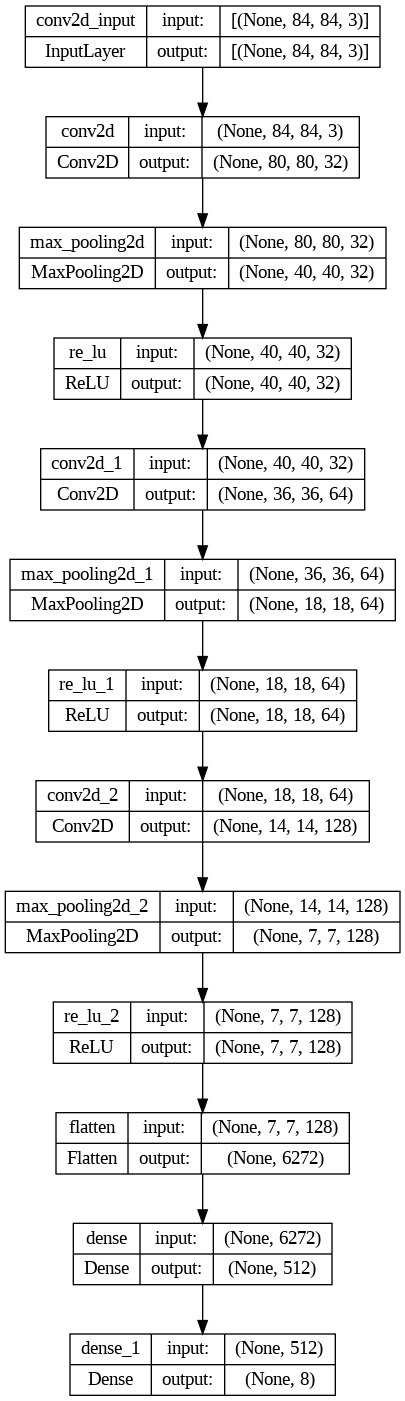

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(DQN_agent.model, to_file='DQN_model.png', show_shapes=True, show_layer_names=True)

---

Save and load model weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save the weights

DQN_agent.model.save_weights('/content/drive/ex1_model_weights')
DQN_agent.targets_model.save_weights('/content/drive/ex2_targets_model_weights')

In [ ]:
# Load the weights

DQN_agent = DQNAgent(env=sokoban_env, init_model=None, init_targets_model=None,
                     num_episodes=num_episodes, maxlen=maxlen, batch_size=batch_size, model_train_n_steps=model_train_n_steps,
                     lr_init=lr_init, lr_decay_rate=lr_decay_rate, lr_decay_steps=lr_decay_steps, clipnorm=clipnorm,
                     epsilon_init=epsilon_init, epsilon_decay=epsilon_decay, epsilon_decay_threshold=epsilon_decay_threshold,
                     tiny_action_lookup=tiny_action_lookup, reward_shaping=reward_shaping)

DQN_agent.model.load_weights('/content/drive/ex2_model_weights')
DQN_agent.targets_model.load_weights('/content/drive/ex2_targets_model_weights')

---

# EX2 - PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1)
# ============================================

In [ ]:
class EnvWrapper(gym.Wrapper):
    def __init__(self, env, dim_room, num_boxes, max_steps, seed=2, mode='tiny_rgb_array',  crop=False,
                 curriculum_learning=False, curriculum_episodes_per_step={1: 150, 2: 350}):
        super().__init__(env)

        self.seed = seed
        self.dim_room = dim_room
        self.num_boxes = num_boxes
        self._max_steps = max_steps
        self._mode = mode
        self._crop = crop

        # Curriculum Learning        
        self.curriculum_learning = curriculum_learning
        self.curriculum_step = 1
        self.curriculum_episodes_per_step = curriculum_episodes_per_step
        self.curriculum_step_episode = 0

        # The wrapper encapsulates and initialize the gym env
        self.env = env(dim_room=self.dim_room, num_boxes=self.num_boxes, max_steps=self._max_steps)
        self.last_state = self.reset()
    
    def xs_observation(self, state):
        if self._mode == 'rgb_array' and not self._crop:
            return state
        elif self._mode == 'rgb_array' and self._crop:
            return state[14:-14, 14:-14, :]
        elif self._mode == 'tiny_rgb_array':
            return state[1:-1, 1:-1, :]
        else:  # grayscale
            return state[1:-1, 1:-1, 0:1]
              
    def step(self, action, reward_shaping=False):
        next_state, reward, done, info = self.env.step(action, observation_mode=self._mode)
        next_state = self.xs_observation(next_state)
        self.num_step += 1
        self._box_position = np.hstack(np.where(self.env.room_state == 4))  # Take box position (4)

        if len(self._box_position) > 0 and reward_shaping:
            distance_to_target = np.sum(np.abs(np.array(self.end_location) - np.array(self._box_position)))
            distance_to_box = -1 + np.sum(np.abs(np.array(self._box_position) - np.array(self.env.player_position)))
            reward -= distance_to_target
            reward -= distance_to_box
        return next_state, reward, done, info
    
    def reset(self, enable_curriculum=True):

        if self.curriculum_learning and enable_curriculum:
            self.env.num_step = 0
            for i in range(1_000):  # stop if environment not found

              if self.seed:
                  self.seed += 1

              # recurively search for appropriate environment                
              state = self.reset(enable_curriculum=False)
              distance_to_target = np.sum(np.abs(np.array(self.end_location) - np.array(self.start_location)))
              if distance_to_target == self.curriculum_step:
                  self.curriculum_step_episode += 1
                  if self.curriculum_step_episode == self.curriculum_episodes_per_step.get(self.curriculum_step, 1_000):
                      self.curriculum_step_episode = 0
                      self.curriculum_step += 1
                  print(f'Curriculum: Distance to target - {distance_to_target}')
                  return state

        if self.seed:
            random.seed(self.seed)
        self.num_step = 0
        state = self.env.reset()
        state = self.env.render(mode=self._mode)

        self.end_location = list(self.env.box_mapping.keys())[0]
        self.start_location = list(self.env.box_mapping.values())[0]
        self._box_position = self.start_location
        state = self.xs_observation(state)
        return state

In [ ]:
max_steps = 70  # @param {type:"number"}
num_episodes = 500  # @param {type:"number"}

maxlen = 20000  # @param {type:"number"}
batch_size = 1024  # @param {type:"number"}

discount_factor = 0.99  # @param {type:"number"}
model_train_n_steps = 5  # @param {type:"number"}

lr_init = 0.0001  # @param {type:"number"}
lr_decay_rate = 0.99  # @param {type:"number"}
lr_decay_steps = 2000  # @param {type:"number"}
clipnorm = 1  # @param {type:"number"}

epsilon_init = 1  # @param {type:"number"}
epsilon_decay = 0.9999  # @param {type:"number"}
epsilon_decay_threshold = 0.2  # @param {type:"number"}

reward_shaping = True  # @param {type:"boolean"}
mode = 'rgb_array'  # @param {type:"string"}

In [ ]:
sokoban_env = EnvWrapper(env=PushAndPullSokobanEnv, dim_room=(7,7), num_boxes=1, max_steps=max_steps, mode=mode, seed=1, curriculum_learning=True)

DQN_agent = DQNAgent(env=sokoban_env, init_model=None, init_targets_model=None,
                    num_episodes=num_episodes, maxlen=maxlen, batch_size=batch_size, model_train_n_steps=model_train_n_steps,
                    lr_init=lr_init, lr_decay_rate=lr_decay_rate, lr_decay_steps=lr_decay_steps, clipnorm=clipnorm,
                    epsilon_init=epsilon_init, epsilon_decay=epsilon_decay, epsilon_decay_threshold=epsilon_decay_threshold,
                    tiny_action_lookup=tiny_action_lookup, reward_shaping=reward_shaping)
DQN_agent.fit(ddqn=True)

Curriculum: Distance to target - 1
Curriculum: Distance to target - 1
Curriculum: Distance to target - 1
Episode: 1/500
[INFO]: {'action.name': 'push left', 'action.moved_player': True, 'action.moved_box': True, 'maxsteps_used': False, 'all_boxes_on_target': True}
Number Of Moves: 12
Total Reward Episode -9.2, Last Reward: 10.9
Total Loss Episode: 0, AVG Loss Episode: 0.0
Current Epsilon: 0.999
Player Position: [4 4]
Actions Count: 9: 3, 4: 2, 12: 1, 1: 2, 2: 2, 11: 1, 3: 1
####################################################################################################
Curriculum: Distance to target - 1


<ipython-input-9-fd4e94b28941>:207: DeprecationWarning:

Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.



Episode: 2/500
[INFO]: {'action.name': 'push down', 'action.moved_player': True, 'action.moved_box': True, 'maxsteps_used': False, 'all_boxes_on_target': True}
Number Of Moves: 17
Total Reward Episode -15.7, Last Reward: 10.9
Total Loss Episode: 0, AVG Loss Episode: 0.0
Current Epsilon: 0.997
Player Position: [2 5]
Actions Count: 11: 3, 12: 2, 9: 3, 3: 3, 4: 2, 1: 2, 2: 2
####################################################################################################
Curriculum: Distance to target - 1
Episode: 3/500
[INFO]: {'action.name': 'push up', 'action.moved_player': True, 'action.moved_box': True, 'maxsteps_used': False, 'all_boxes_on_target': True}
Number Of Moves: 1
Total Reward Episode 10.9, Last Reward: 10.9
Total Loss Episode: 0, AVG Loss Episode: 0.0
Current Epsilon: 0.997
Player Position: [2 1]
Actions Count: 1: 1
####################################################################################################
Curriculum: Distance to target - 1
Episode: 4/500
[INFO

KeyboardInterrupt: ignored

---
**Reward Shaping with max_step of 500 and model is DDQN**
* max_steps = 60
* num_episodes = 500
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.9995
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

distance_to_target 3


In [ ]:
DQN_agent.mid_train_learning_video()

In [ ]:
sokoban_env = EnvWrapper(env=PushAndPullSokobanEnv, dim_room=(7,7), num_boxes=1, max_steps=max_steps, mode=mode, seed=None, curriculum_learning=True)
video_func(sokoban_env, DQN_agent)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---
**Reward Shaping with max_step of 500 and model is DDQN and Curriculum Learning**
* max_steps = 500
* num_episodes = 500
* maxlen = 2000 
* batch_size = 64
* discount_factor = 0.99
* model_train_n_steps = 10
* lr_init = 0.0001
* lr_decay_rate = 0.9
* lr_decay_steps = 1000
* clipnorm = 1
* epsilon_init = 1
* epsilon_decay = 0.99995
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* mode = 'rgb_array'


In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

distance_to_target 3


/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



---

**Reward Shaping with max_step of 70 and model is DDQN and Curriculum Learning**
* max_steps = 70  
* num_episodes = 500 
* maxlen = 20000
* batch_size = 1024 
* discount_factor = 0.99 
* model_train_n_steps = 5 
* lr_init = 0.0001 
* lr_decay_rate = 0.99
* lr_decay_steps = 2000
* clipnorm = 1 
* epsilon_init = 1 
* epsilon_decay = 0.9999
* epsilon_decay_threshold = 0.2
* reward_shaping = True
* mode = 'rgb_array'

In [ ]:
DQN_agent.show_rewards()
DQN_agent.show_loss()
DQN_agent.predict(fps=3)

Curriculum: Distance to target - 2


/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



In [ ]:
DQN_agent.mid_train_learning_video(fps=3)

In [ ]:
# Save the weights
DQN_agent.model.save_weights('/content/drive/ex2_model_weights')

---